PyTorch version: 2.6.0+cu124
CUDA available: True
Using device: cpu
Training on 60000 samples, testing on 10000 samples
Creating imsnn model...
Model created successfully!
Starting training...
Epoch 1, Batch 0: Loss = 2.3039, Acc = 6.25%, Spikes = 0.0001
Epoch 1, Batch 10: Loss = 2.3028, Acc = 7.95%, Spikes = 0.0000
Epoch 1, Batch 20: Loss = 2.3037, Acc = 9.08%, Spikes = 0.0000
Epoch 1, Batch 30: Loss = 2.3039, Acc = 8.77%, Spikes = 0.0000
Epoch 1, Batch 40: Loss = 2.3041, Acc = 8.84%, Spikes = 0.0000
Epoch 1, Batch 50: Loss = 2.3012, Acc = 8.64%, Spikes = 0.0000
Epoch 1, Batch 60: Loss = 2.3032, Acc = 8.76%, Spikes = 0.0000
Epoch 1, Batch 70: Loss = 2.3003, Acc = 8.89%, Spikes = 0.0000
Epoch 1, Batch 80: Loss = 2.2993, Acc = 9.07%, Spikes = 0.0000
Epoch 1, Batch 90: Loss = 2.3057, Acc = 9.24%, Spikes = 0.0000
Epoch 1, Batch 100: Loss = 2.3016, Acc = 9.34%, Spikes = 0.0000
Epoch 1, Batch 110: Loss = 2.2999, Acc = 9.74%, Spikes = 0.0000
Epoch 1, Batch 120: Loss = 2.3049, Acc = 9.61%, Sp

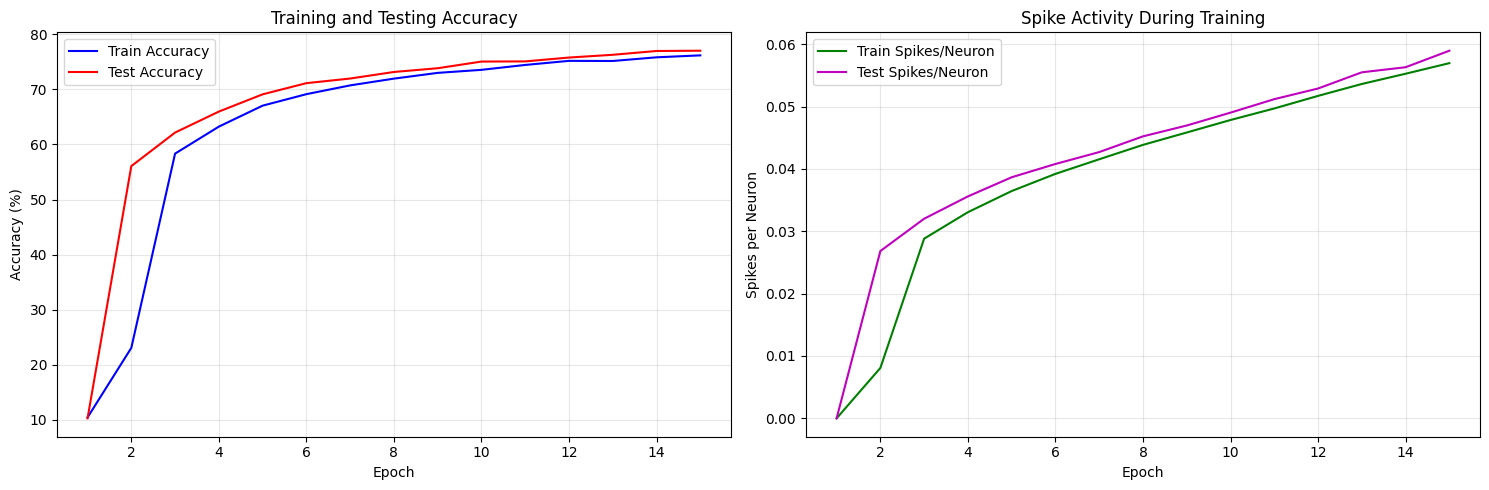

Model saved to imsnn_model.pth
Done!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Explicitly use CPU for now to verify it works
device = torch.device("cpu")
print(f"Using device: {device}")

# Reduced hyperparameters
batch_size = 32
time_steps = 20
input_size = 784
hidden_size = 200  # Reduced significantly
output_size = 10
beta = 0.99
theta = 1.0
lr = 1e-4
epochs = 15
model_type = 'imsnn'  # 'imsnn' or 'snn'

# For tracking metrics
metrics = {
    'epoch': [], 'train_loss': [], 'train_acc': [], 'test_acc': [],
    'train_spikes': [], 'test_spikes': [], 'layer_spikes': []
}

# Data Loading - use a smaller subset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# # Use a much smaller subset for testing
# train_size = 5000  # Just 5000 samples
# test_size = 1000   # Just 1000 samples
# indices = list(range(len(train_dataset)))
# test_indices = list(range(len(test_dataset)))
# train_dataset = torch.utils.data.Subset(train_dataset, indices[:train_size])
# test_dataset = torch.utils.data.Subset(test_dataset, test_indices[:test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {len(train_dataset)} samples, testing on {len(test_dataset)} samples")

# Very simple Poisson Encoder
def poisson_encoder(image, time_steps, fr_min=28.5, fr_max=100.0):
    dt = 1e-3
    rates = (fr_min + (fr_max - fr_min) * image) * dt
    spikes = torch.rand(time_steps, *image.shape) < rates.unsqueeze(0)
    return spikes.float()

# Simplified Surrogate Gradient Function
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > theta).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad = grad_output * 0.3 * torch.exp(-0.5 * torch.abs(input - theta))
        return grad

spike_fn = SurrGradSpike.apply

# Simple implementation of ISI Layer
class ISILayer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)  # Use standard linear layer internally
        self.mu = nn.Parameter(torch.ones(output_size) * 12.0)  # Single mu per output neuron
        self.sigma = nn.Parameter(torch.ones(output_size) * 4.0)  # Single sigma per output neuron

    def forward(self, s_in, phi_prev):
        # Regular linear transformation
        output = self.linear(s_in)

        # Calculate average ISI for each input
        avg_phi = phi_prev.mean(dim=1, keepdim=True)

        # Simple modulation
        # Calculate Gaussian factor - one per output neuron
        phi_factors = torch.exp(-2.0 * ((avg_phi - self.mu.unsqueeze(0)) / self.sigma.unsqueeze(0))**2)

        # Modulate output
        modulated_output = output * phi_factors

        return modulated_output

# LIF Neuron
class LIFNeuron(nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.layer_size = layer_size
        self.mem = None
        self.phi = None

    def reset_state(self, batch_size):
        self.mem = torch.zeros(batch_size, self.layer_size)
        self.phi = torch.zeros(batch_size, self.layer_size)

    def forward(self, I):
        self.mem = beta * self.mem + I
        spikes = spike_fn(self.mem)
        self.mem = self.mem * (1 - spikes)
        self.phi = (1 + self.phi) * (1 - spikes)
        return spikes

# Neural Network Model
class SNN(nn.Module):
    def __init__(self, model_type='imsnn'):
        super().__init__()
        self.model_type = model_type

        if model_type == 'imsnn':
            self.fc1 = ISILayer(input_size, hidden_size)
        else:
            self.fc1 = nn.Linear(input_size, hidden_size)

        self.lif1 = LIFNeuron(hidden_size)

        if model_type == 'imsnn':
            self.fc2 = ISILayer(hidden_size, output_size)
        else:
            self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(1)
        self.lif1.reset_state(batch_size)

        if self.model_type == 'imsnn':
            input_phi = torch.zeros(batch_size, input_size)

        outputs = []
        spike_counts = 0

        for t in range(x.size(0)):
            s_in = x[t]

            if self.model_type == 'imsnn':
                input_phi = (1 + input_phi) * (1 - s_in)
                I1 = self.fc1(s_in, input_phi)
            else:
                I1 = self.fc1(s_in)

            s1 = self.lif1(I1)
            spike_counts += s1.sum()

            if self.model_type == 'imsnn':
                I2 = self.fc2(s1, self.lif1.phi)
            else:
                I2 = self.fc2(s1)

            outputs.append(I2)

        avg_spikes_per_neuron = spike_counts / (batch_size * hidden_size * x.size(0))
        return torch.stack(outputs).mean(dim=0), avg_spikes_per_neuron

# Initialize Model and Optimizer
print(f"Creating {model_type} model...")
model = SNN(model_type).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
print("Model created successfully!")

# Training Loop
print("Starting training...")
start_time = time.time()
best_accuracy = 0

try:
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        train_spikes = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Generate spikes
            spikes = poisson_encoder(images, time_steps)

            # Forward pass
            outputs, avg_spikes = model(spikes)
            loss = criterion(outputs, labels)

            # Add spike regularization
            if model_type == 'imsnn':
                loss += 0.2 * avg_spikes

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            train_spikes += avg_spikes.item()

            # Print progress
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}: Loss = {loss.item():.4f}, Acc = {100*correct/total:.2f}%, Spikes = {avg_spikes.item():.4f}")

        # Epoch stats
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_spikes_avg = train_spikes / len(train_loader)

        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        test_spikes = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)

                # Generate spikes
                spikes = poisson_encoder(images, time_steps)

                # Forward pass
                outputs, avg_spikes = model(spikes)
                loss = criterion(outputs, labels)

                # Track metrics
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                test_spikes += avg_spikes.item()

        # Test stats
        test_acc = 100 * correct / total
        test_spikes_avg = test_spikes / len(test_loader)
        test_loss_avg = test_loss / len(test_loader)

        scheduler.step(test_loss_avg)

        # Store metrics
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss_avg)
        metrics['train_acc'].append(train_acc)
        metrics['test_acc'].append(test_acc)
        metrics['train_spikes'].append(train_spikes_avg)
        metrics['test_spikes'].append(test_spikes_avg)
        metrics['layer_spikes'].append(test_spikes_avg)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:.2f}% | Train Spikes: {train_spikes_avg:.4f}")
        print(f"Test Acc: {test_acc:.2f}% | Test Spikes: {test_spikes_avg:.4f}")
        print('-' * 60)

        # Update best accuracy
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_epoch = epoch
except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

# Calculate total time and print final results
total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')

if len(metrics['train_acc']) > 0:
    print(f'Final train accuracy: {metrics["train_acc"][-1]:.2f}%')
    print(f'Final test accuracy: {metrics["test_acc"][-1]:.2f}%')
    print(f'Average spikes per neuron: {metrics["test_spikes"][-1]:.4f}')
    print(f'Best accuracy: {max(metrics["test_acc"]):.2f}%')
else:
    print("No training completed.")

# Plot results
plt.figure(figsize=(15, 5))

if len(metrics['epoch']) > 0:
    # Accuracy and loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics['epoch'], metrics['train_acc'], 'b-', label='Train Accuracy')
    plt.plot(metrics['epoch'], metrics['test_acc'], 'r-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Testing Accuracy')
    plt.grid(True, alpha=0.3)

    # Spike activity plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics['epoch'], metrics['train_spikes'], 'g-', label='Train Spikes/Neuron')
    plt.plot(metrics['epoch'], metrics['test_spikes'], 'm-', label='Test Spikes/Neuron')
    plt.xlabel('Epoch')
    plt.ylabel('Spikes per Neuron')
    plt.legend()
    plt.title('Spike Activity During Training')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_type}_results.png', dpi=300)
    plt.show()
else:
    print("No data to plot.")

# Save model if we have data
if len(metrics['train_acc']) > 0:
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics,
            'model_type': model_type
        }, f'{model_type}_model.pth')
        print(f"Model saved to {model_type}_model.pth")
    except Exception as e:
        print(f"Error saving model: {e}")

print("Done!")

PyTorch version: 2.6.0+cu124
CUDA available: True
Using device: cpu
Training on 60000 samples, testing on 10000 samples
Creating snn model...
Model created successfully!
Starting training...
Epoch 1, Batch 0: Loss = 2.2963, Acc = 15.62%, Spikes = 0.0061
Epoch 1, Batch 10: Loss = 2.2974, Acc = 9.38%, Spikes = 0.0054
Epoch 1, Batch 20: Loss = 2.2992, Acc = 9.82%, Spikes = 0.0062
Epoch 1, Batch 30: Loss = 2.3039, Acc = 9.98%, Spikes = 0.0055
Epoch 1, Batch 40: Loss = 2.3115, Acc = 10.67%, Spikes = 0.0061
Epoch 1, Batch 50: Loss = 2.3002, Acc = 10.78%, Spikes = 0.0062
Epoch 1, Batch 60: Loss = 2.3015, Acc = 10.76%, Spikes = 0.0063
Epoch 1, Batch 70: Loss = 2.3020, Acc = 10.52%, Spikes = 0.0063
Epoch 1, Batch 80: Loss = 2.3116, Acc = 10.49%, Spikes = 0.0059
Epoch 1, Batch 90: Loss = 2.2858, Acc = 11.09%, Spikes = 0.0058
Epoch 1, Batch 100: Loss = 2.2936, Acc = 11.54%, Spikes = 0.0058
Epoch 1, Batch 110: Loss = 2.3005, Acc = 11.57%, Spikes = 0.0050
Epoch 1, Batch 120: Loss = 2.2967, Acc = 11

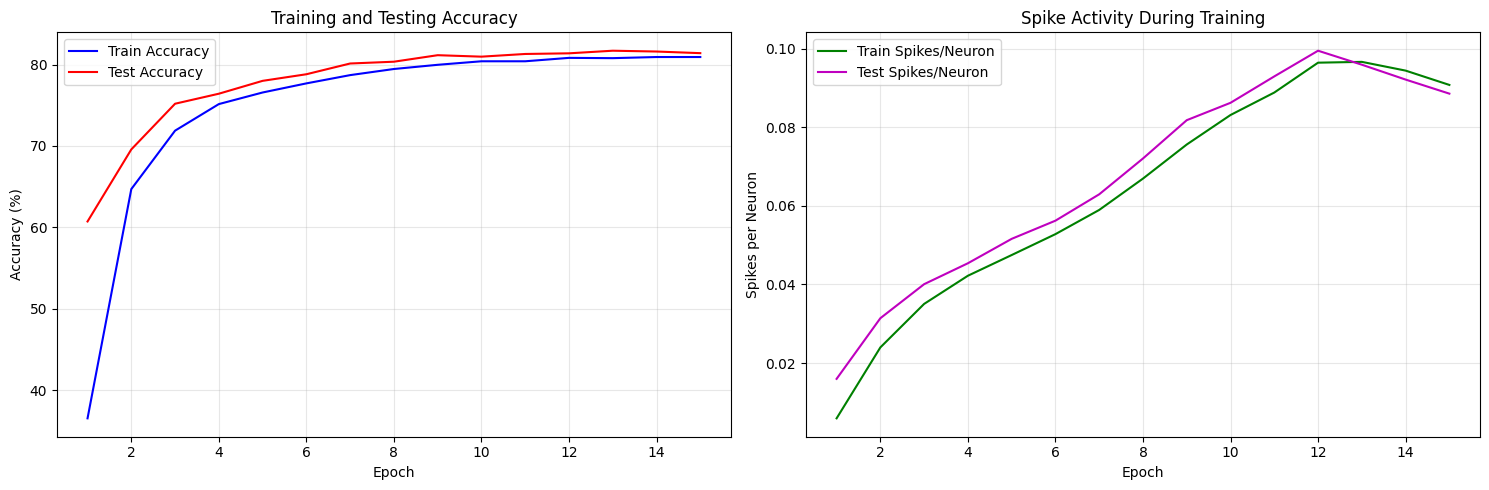

Model saved to snn_model.pth
Done!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Explicitly use CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# Reduced hyperparameters
batch_size = 32
time_steps = 20
input_size = 784
hidden_size = 200  # Reduced significantly
output_size = 10
beta = 0.99
theta = 1.0
lr = 1e-4
epochs = 15
model_type = 'snn'  # 'imsnn' or 'snn'

# For tracking metrics
metrics = {
    'epoch': [], 'train_loss': [], 'train_acc': [], 'test_acc': [],
    'train_spikes': [], 'test_spikes': [], 'layer_spikes': []
}

# Data Loading - use a smaller subset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# # Use a much smaller subset for testing
# train_size = 5000  # Just 5000 samples
# test_size = 1000   # Just 1000 samples
# indices = list(range(len(train_dataset)))
# test_indices = list(range(len(test_dataset)))
# train_dataset = torch.utils.data.Subset(train_dataset, indices[:train_size])
# test_dataset = torch.utils.data.Subset(test_dataset, test_indices[:test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {len(train_dataset)} samples, testing on {len(test_dataset)} samples")

# Very simple Poisson Encoder
def poisson_encoder(image, time_steps, fr_min=28.5, fr_max=100.0):
    dt = 1e-3
    rates = (fr_min + (fr_max - fr_min) * image) * dt
    spikes = torch.rand(time_steps, *image.shape) < rates.unsqueeze(0)
    return spikes.float()

# Simplified Surrogate Gradient Function
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > theta).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad = grad_output * 0.3 * torch.exp(-0.5 * torch.abs(input - theta))
        return grad

spike_fn = SurrGradSpike.apply

# Simple implementation of ISI Layer
class ISILayer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)  # Use standard linear layer internally
        self.mu = nn.Parameter(torch.ones(output_size) * 12.0)  # Single mu per output neuron
        self.sigma = nn.Parameter(torch.ones(output_size) * 4.0)  # Single sigma per output neuron

    def forward(self, s_in, phi_prev):
        # Regular linear transformation
        output = self.linear(s_in)

        # Calculate average ISI for each input
        avg_phi = phi_prev.mean(dim=1, keepdim=True)

        # Simple modulation
        # Calculate Gaussian factor - one per output neuron
        phi_factors = torch.exp(-2.0 * ((avg_phi - self.mu.unsqueeze(0)) / self.sigma.unsqueeze(0))**2)

        # Modulate output
        modulated_output = output * phi_factors

        return modulated_output

# LIF Neuron
class LIFNeuron(nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.layer_size = layer_size
        self.mem = None
        self.phi = None

    def reset_state(self, batch_size):
        self.mem = torch.zeros(batch_size, self.layer_size)
        self.phi = torch.zeros(batch_size, self.layer_size)

    def forward(self, I):
        self.mem = beta * self.mem + I
        spikes = spike_fn(self.mem)
        self.mem = self.mem * (1 - spikes)
        self.phi = (1 + self.phi) * (1 - spikes)
        return spikes

# Neural Network Model
class SNN(nn.Module):
    def __init__(self, model_type='imsnn'):
        super().__init__()
        self.model_type = model_type

        if model_type == 'imsnn':
            self.fc1 = ISILayer(input_size, hidden_size)
        else:
            self.fc1 = nn.Linear(input_size, hidden_size)

        self.lif1 = LIFNeuron(hidden_size)

        if model_type == 'imsnn':
            self.fc2 = ISILayer(hidden_size, output_size)
        else:
            self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(1)
        self.lif1.reset_state(batch_size)

        if self.model_type == 'imsnn':
            input_phi = torch.zeros(batch_size, input_size)

        outputs = []
        spike_counts = 0

        for t in range(x.size(0)):
            s_in = x[t]

            if self.model_type == 'imsnn':
                input_phi = (1 + input_phi) * (1 - s_in)
                I1 = self.fc1(s_in, input_phi)
            else:
                I1 = self.fc1(s_in)

            s1 = self.lif1(I1)
            spike_counts += s1.sum()

            if self.model_type == 'imsnn':
                I2 = self.fc2(s1, self.lif1.phi)
            else:
                I2 = self.fc2(s1)

            outputs.append(I2)

        avg_spikes_per_neuron = spike_counts / (batch_size * hidden_size * x.size(0))
        return torch.stack(outputs).mean(dim=0), avg_spikes_per_neuron

# Initialize Model and Optimizer
print(f"Creating {model_type} model...")
model = SNN(model_type).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
print("Model created successfully!")

# Training Loop
print("Starting training...")
start_time = time.time()
best_accuracy = 0

try:
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        train_spikes = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Generate spikes
            spikes = poisson_encoder(images, time_steps)

            # Forward pass
            outputs, avg_spikes = model(spikes)
            loss = criterion(outputs, labels)

            # Add spike regularization
            if model_type == 'imsnn':
                loss += 0.2 * avg_spikes

            elif model_type == 'snn':
                loss += 0.001 * avg_spikes

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            train_spikes += avg_spikes.item()

            # Print progress
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}: Loss = {loss.item():.4f}, Acc = {100*correct/total:.2f}%, Spikes = {avg_spikes.item():.4f}")

        # Epoch stats
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_spikes_avg = train_spikes / len(train_loader)

        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        test_spikes = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)

                # Generate spikes
                spikes = poisson_encoder(images, time_steps)

                # Forward pass
                outputs, avg_spikes = model(spikes)
                loss = criterion(outputs, labels)

                # Track metrics
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                test_spikes += avg_spikes.item()

        # Test stats
        test_acc = 100 * correct / total
        test_spikes_avg = test_spikes / len(test_loader)
        test_loss_avg = test_loss / len(test_loader)

        scheduler.step(test_loss_avg)

        # Store metrics
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss_avg)
        metrics['train_acc'].append(train_acc)
        metrics['test_acc'].append(test_acc)
        metrics['train_spikes'].append(train_spikes_avg)
        metrics['test_spikes'].append(test_spikes_avg)
        metrics['layer_spikes'].append(test_spikes_avg)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:.2f}% | Train Spikes: {train_spikes_avg:.4f}")
        print(f"Test Acc: {test_acc:.2f}% | Test Spikes: {test_spikes_avg:.4f}")
        print('-' * 60)

        # Update best accuracy
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_epoch = epoch
except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

# Calculate total time and print final results
total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')

if len(metrics['train_acc']) > 0:
    print(f'Final train accuracy: {metrics["train_acc"][-1]:.2f}%')
    print(f'Final test accuracy: {metrics["test_acc"][-1]:.2f}%')
    print(f'Average spikes per neuron: {metrics["test_spikes"][-1]:.4f}')
    print(f'Best accuracy: {max(metrics["test_acc"]):.2f}%')
else:
    print("No training completed.")

# Plot results
plt.figure(figsize=(15, 5))

if len(metrics['epoch']) > 0:
    # Accuracy and loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics['epoch'], metrics['train_acc'], 'b-', label='Train Accuracy')
    plt.plot(metrics['epoch'], metrics['test_acc'], 'r-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Testing Accuracy')
    plt.grid(True, alpha=0.3)

    # Spike activity plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics['epoch'], metrics['train_spikes'], 'g-', label='Train Spikes/Neuron')
    plt.plot(metrics['epoch'], metrics['test_spikes'], 'm-', label='Test Spikes/Neuron')
    plt.xlabel('Epoch')
    plt.ylabel('Spikes per Neuron')
    plt.legend()
    plt.title('Spike Activity During Training')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_type}_results.png', dpi=300)
    plt.show()
else:
    print("No data to plot.")

# Save model if we have data
if len(metrics['train_acc']) > 0:
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics,
            'model_type': model_type
        }, f'{model_type}_model.pth')
        print(f"Model saved to {model_type}_model.pth")
    except Exception as e:
        print(f"Error saving model: {e}")

print("Done!")